# Chem 277B - Spring 2025 - Homework 5
## CNN - Image Processing Using an Encoder-Decoder Structure
*Submit this notebook to bCourses to receive a credit for this assignment.*
<br>
due: **Apr 18th 2025** 
<br>
**Please upload both, the .ipynb file and the corresponding .pdf**<br>
<br>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import glob as gl
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [3]:
# Loading parasitized images 
Im_Path = 'cell_images/Parasitized/'
form = '.png'
path_parasite = Im_Path + '*' + form
parasitized = gl.glob(path_parasite)

In [4]:
# Loading healthy images 
Im_Path2 = 'cell_images/Uninfected/'
path_healthy = Im_Path2 + '*' + form
healthy = gl.glob(path_healthy)

In [5]:
# convert images to greyscale and numpy arrays
gray_parasitized = [np.array(Image.open(img_path).convert('L').resize((64,64))) for img_path in parasitized]
gray_healthy = [np.array(Image.open(img_path).convert('L').resize((64,64))) for img_path in healthy]

In [6]:
gray_parasitized[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
# rescale
gray_parasitized = np.array(gray_parasitized, dtype=np.float32) / 255.0
gray_healthy = np.array(gray_healthy, dtype=np.float32) / 255.0


In [8]:
# Assuming gray_parasitized_np and gray_healthy_np are shape (n, 128, 128)
# Training only to learn what healthy images look like
X_training_index = int(len(gray_healthy) * 0.8)
X = gray_healthy[ : X_training_index]
X_healthy_unseen = gray_healthy[X_training_index : ]

# Rescale
# X = X / 255.0
# X_healthy_unseen = X_healthy_unseen / 255.0
# gray_parasitized = gray_parasitized / 255.0

# Add channel dimension: (num_samples, height, width, 1)
X = np.expand_dims(X, axis=-1)
X_healthy_unseen = np.expand_dims(X_healthy_unseen, axis=-1)
gray_parasitized = np.expand_dims(gray_parasitized, axis=-1)

# Shuffle
X = shuffle(X, random_state=42)


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Dense, Reshape

input_img = Input(shape=(64, 64, 1))  # Input layer

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Dense layer (i.e. "bottleneck")
x = Flatten()(x)
encoded = Dense(8*8*8, activation='relu', name='latent_vector')(x) 

# Decoder
x = Dense(16 * 16 * 8, activation='relu')(encoded)
x = Reshape((16, 16, 8))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 1)      │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,689 (8.02 MB)

 Trainable params: 2,101,689 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
autoencoder.fit(
    X, X,  # input = output
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.2
)


Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0302 - val_loss: 0.0088
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 12/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
print(X.shape, X_healthy_unseen.shape, gray_parasitized.shape)

(11023, 64, 64, 1) (2756, 64, 64, 1) (13779, 64, 64, 1)


In [12]:
reconstructed_parasites = autoencoder.predict(gray_parasitized)
reconstructed_healthy = autoencoder.predict(X_healthy_unseen)

reconstruction_error_parasite = np.mean((gray_parasitized - reconstructed_parasites) ** 2, axis=(1,2,3))
reconstruction_error_healthy = np.mean((X_healthy_unseen - reconstructed_healthy) ** 2, axis=(1,2,3))

431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [13]:
np.mean(reconstruction_error_parasite)

0.0044584256

In [14]:
np.mean(reconstruction_error_healthy)

0.0030310743

In [69]:
threshold = np.percentile(reconstruction_error_healthy, 50)  # Top 5% of healthy errors

# 1 = parasitized, 0 = healthy
preds_healthy = (reconstruction_error_healthy > threshold).astype(int)
preds_parasite = (reconstruction_error_parasite > threshold).astype(int)

y_true = np.concatenate([np.zeros_like(preds_healthy), np.ones_like(preds_parasite)])
y_pred = np.concatenate([preds_healthy, preds_parasite])

print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parasitized']))


              precision    recall  f1-score   support

     Healthy       0.60      0.50      0.55      2756
 Parasitized       0.90      0.93      0.92     13779

    accuracy                           0.86     16535
   macro avg       0.75      0.72      0.73     16535
weighted avg       0.85      0.86      0.86     16535



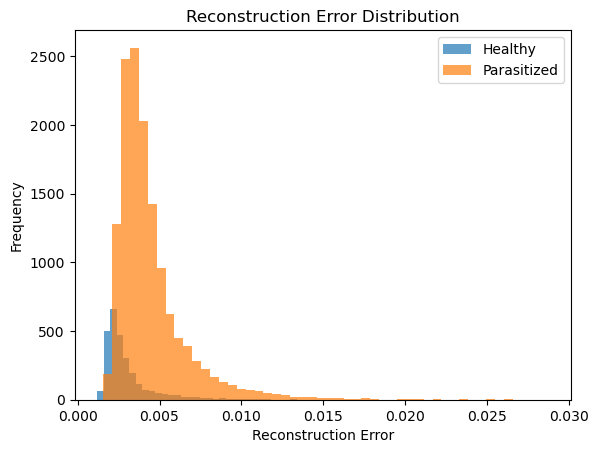

In [16]:
plt.hist(reconstruction_error_healthy, bins=50, alpha=0.7, label='Healthy')
plt.hist(reconstruction_error_parasite, bins=50, alpha=0.7, label='Parasitized')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

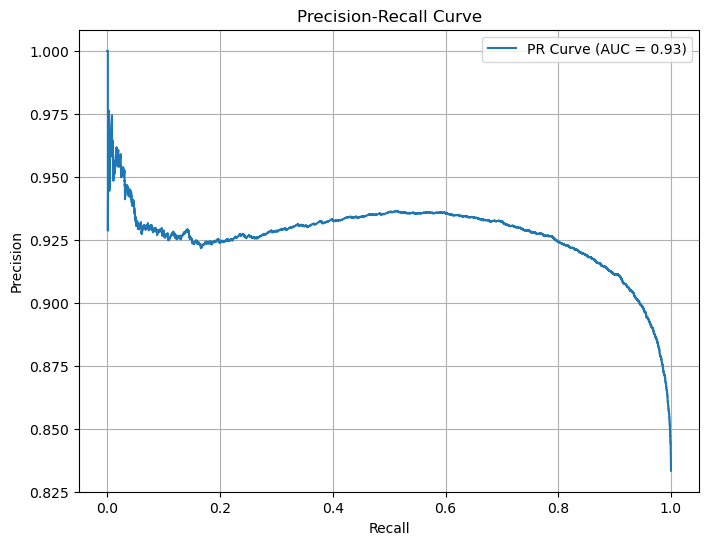

In [17]:
y_true = np.concatenate([np.zeros_like(reconstruction_error_healthy), np.ones_like(reconstruction_error_parasite)])  # 0 for healthy, 1 for parasitized
errors = np.concatenate([reconstruction_error_healthy, reconstruction_error_parasite])

# precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, errors)

# Area Under Curve (AUC) for Precision-Recall curve
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [87]:
# 100 mixed samples
gray_parasitized_50_idx = np.random.choice(len(gray_parasitized), size=50, replace=False)
X_healthy_unseen_50_idx = np.random.choice(len(X_healthy_unseen), size=50, replace=False)

gray_parasitized_50 = gray_parasitized[gray_parasitized_50_idx]
X_healthy_unseen_50 = X_healthy_unseen[X_healthy_unseen_50_idx]

mixed_100_samples = np.concatenate((gray_parasitized_50, X_healthy_unseen_50))

# True labels: 1 for parasitized, 0 for healthy
mixed_100_labels = np.concatenate((np.ones(50), np.zeros(50)), axis=0)

mixed_100_samples, mixed_100_labels = shuffle(mixed_100_samples, mixed_100_labels, random_state=42)

reconstructed_mix = autoencoder.predict(mixed_100_samples)

reconstruction_error_mix= np.mean((mixed_100_samples - reconstructed_mix) ** 2, axis=(1,2,3))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [89]:
np.mean(reconstruction_error_parasite)

0.0044584256

In [91]:
predicted_labels = (reconstruction_error_mix > threshold).astype(int)

In [93]:
print("Confusion Matrix:")
print(confusion_matrix(mixed_100_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(mixed_100_labels, predicted_labels, target_names=["Healthy", "Parasitized"]))

Confusion Matrix:
[[33 17]
 [ 2 48]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.66      0.78        50
 Parasitized       0.74      0.96      0.83        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

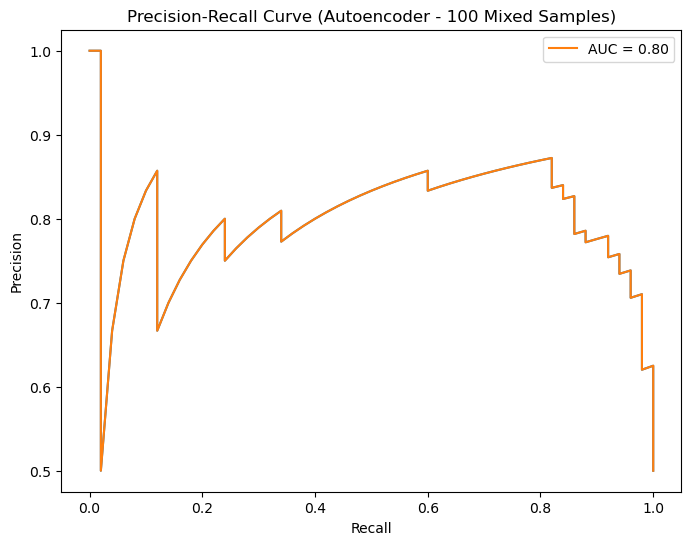

In [95]:
precision, recall, thresholds = precision_recall_curve(mixed_100_labels, reconstruction_error_mix)

pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Autoencoder - 100 Mixed Samples)')
line, = plt.plot(recall, precision, label='PR Curve')
plt.legend([line], [f'AUC = {pr_auc:.2f}'])
plt


# Note to self: 
Recall on healthy images is high because model was mainly trained on healthy images. 
Like a human, recall is better on things that have been seen before.

High precision on parasitized images mean we are identifying parasitized images correctly.
Low precision on healthy images mean we are not identifying healthy images correctly (i.e. we mis-identify them as parasitized.
The model is labeling more images as parasitized rather than healthy. This is important for anomaly detection so truly parasitized images are not mis-identified as healthy. 

# Classification report with dense layer of 2 neurons:

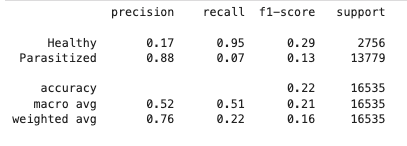

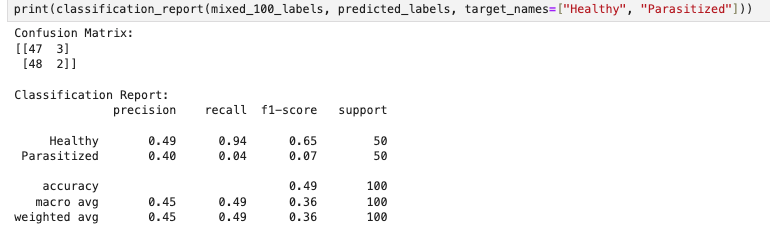

# Classification report with dense layer of 8 or (2 x 2 x 2) neurons:

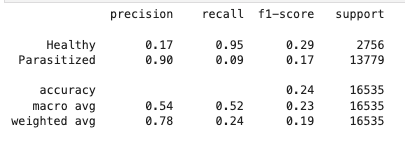

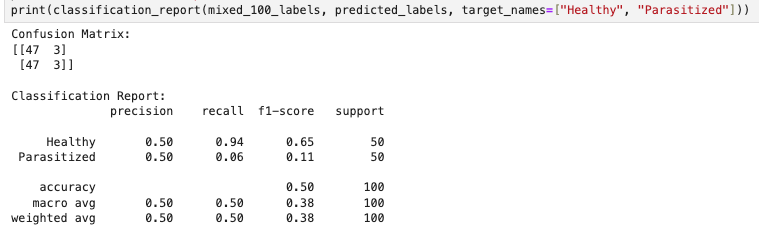

## Classification report with dense layer of 512 or (8 x 8 x 8) neurons: 
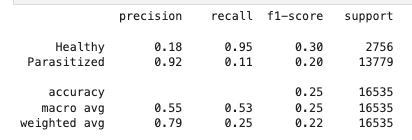

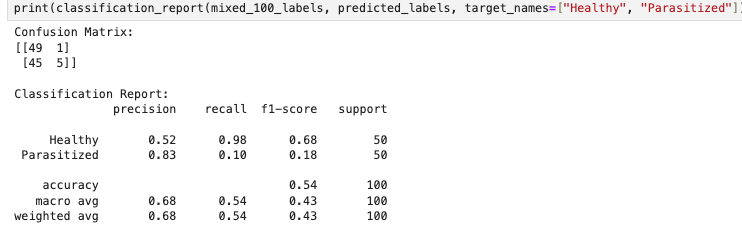


## Classification report with dense layer of (16 x 16 x 16) neurons 

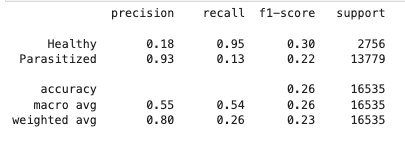

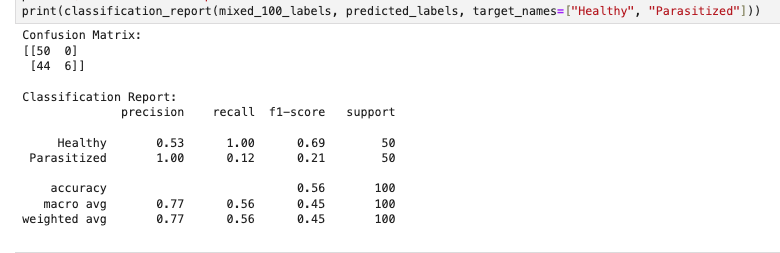

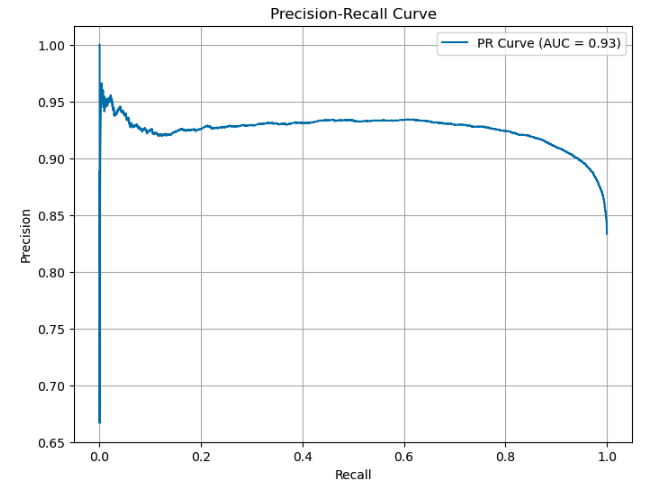

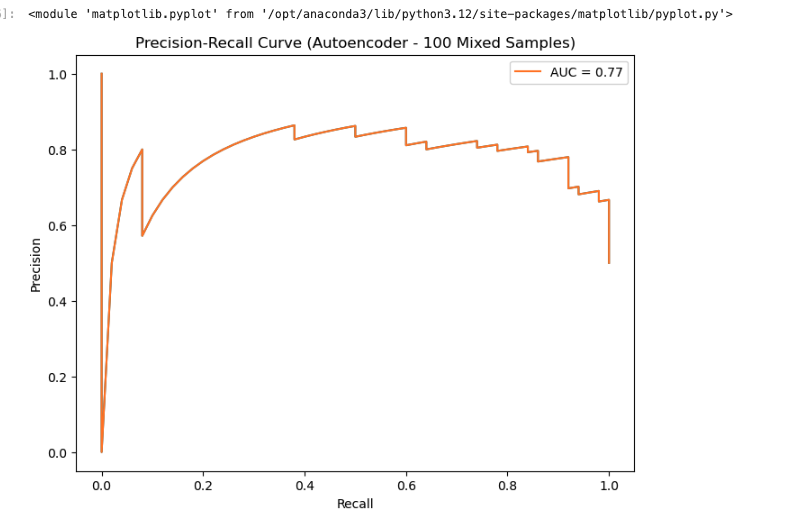

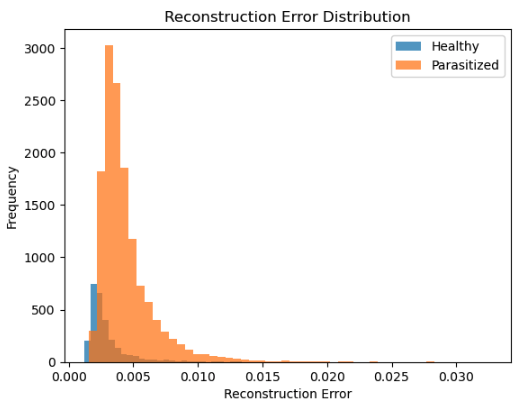

# <mark> Classification report with dense layer of (8 x 8 x 8) neurons in bottleneck / latent space. (Best and submitted.)

Threshold adjusted to 50% improved accuracy and F1 score. 

Reconstruction error of parasitized is still higher than reconstruction error of healthy images.

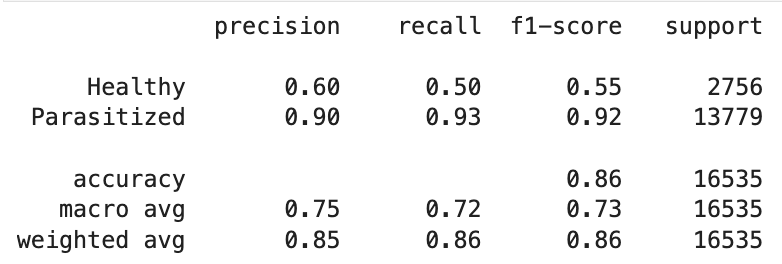

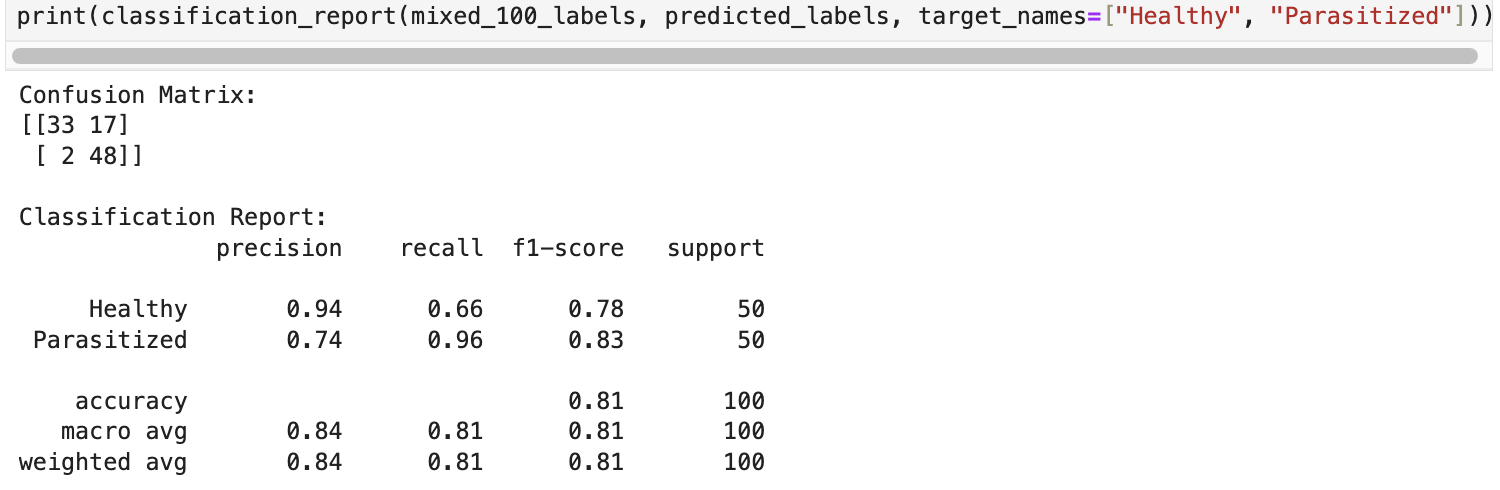

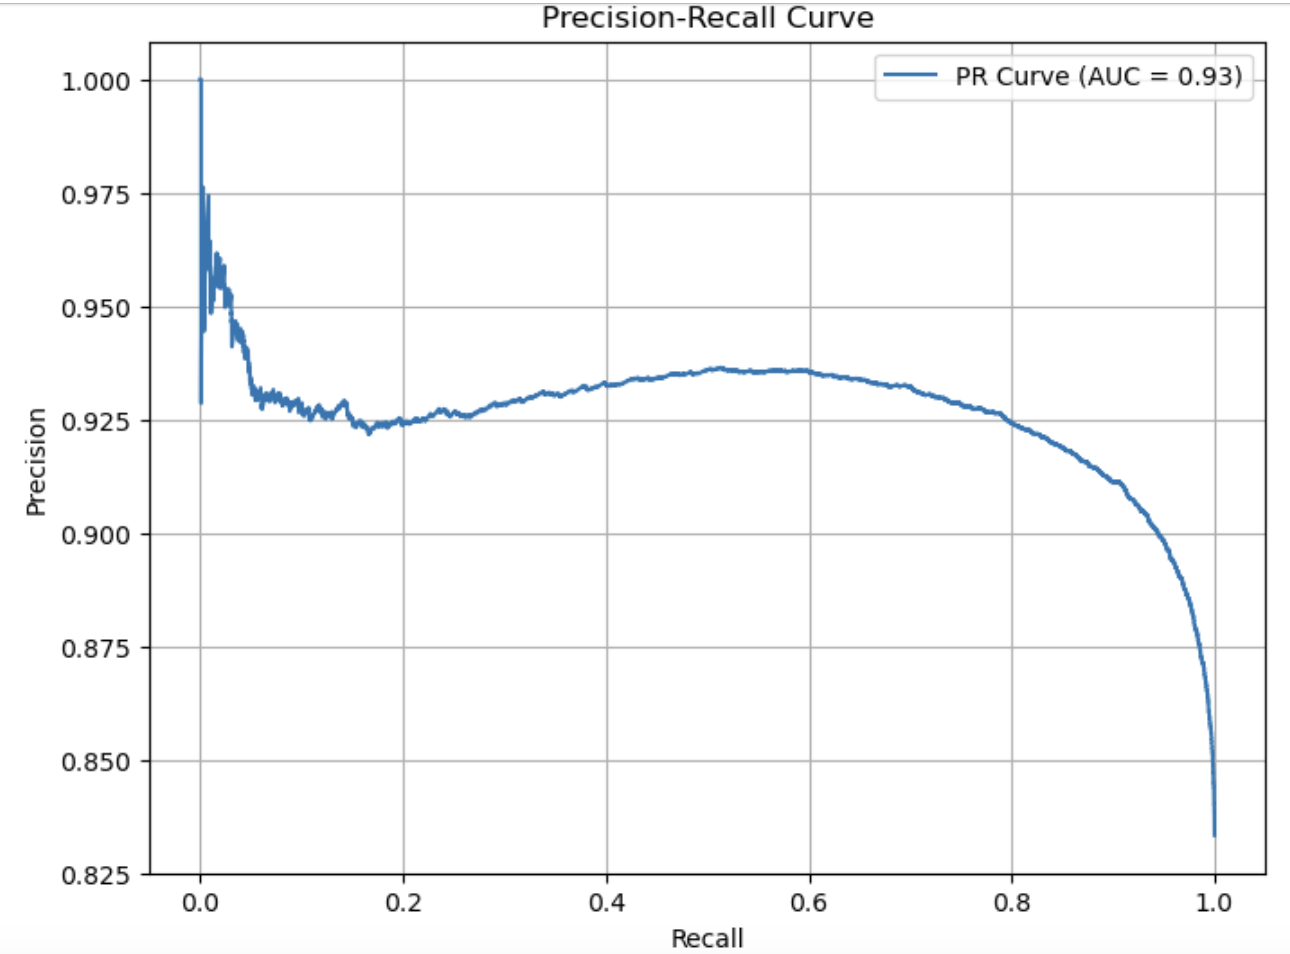

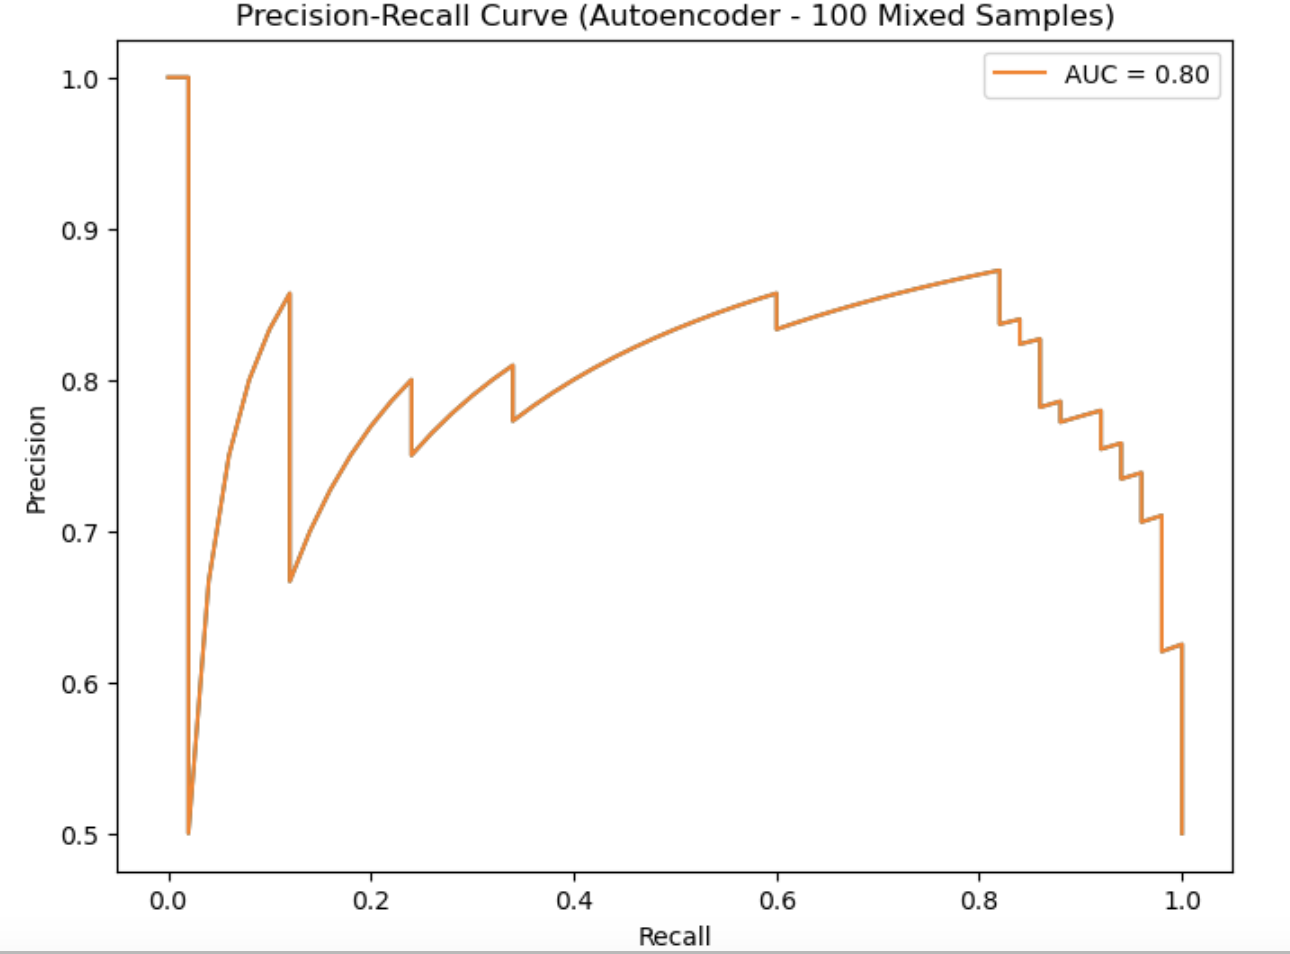

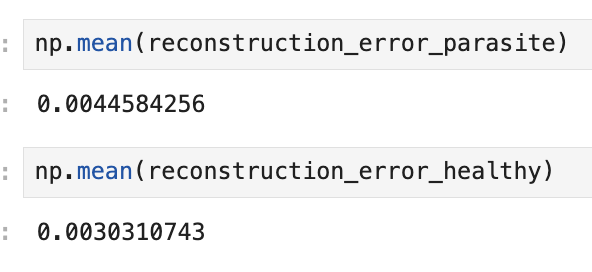

## 60 Points Total

**Problem**

Your task is building an anomaly detection model to identify parasitized cells among images of infected and uninfected cells using a deep learning autoencoder (**do not use VAE. Please use AE**) structure (see **tutorial 8** at *bCourses*). The goal is to develop a system that detects anomalies based on reconstruction errors.<br>
The learning goal of this homework assignment is to work on a real-life scenario with a realistic workflow. This task also serves a preparation for the Capstone Project concerning complexity and difficulty. 

## Note: Optimize for Computational Efficiency
Autoencoders require significant computational resources, so consider the following strategies to reduce computation time while maintaining accuracy:

**Use Smaller Image Sizes**: Start with 64, 32, or even 16 pixels. Smaller images can drastically cut computational cost.
Reduce Filters and Layers: Experiment with fewer filters in each layer and avoid building a very dense network. Aim for a trade-off between model complexity and compute efficiency.<br>
<br>

**Skip the Final Conv2D Layer**: Instead of reconstructing at full resolution, consider using a smaller output size, which reduces the computation load without sacrificing much accuracy.<br>


**Consider a Shallow Network**: A simpler encoder-decoder structure with fewer layers may still work effectively for anomaly detection.<br>

**Preprocess Images:** Apply preprocessing techniques such as thresholding to simplify images before passing them through the autoencoder. Smarter preprocessing may reduce the need for a dense network. You may also make this a single channel image with smart pre processing.


These adjustments are intended to balance computational efficiency with detection accuracy. Use these hints to guide your network design and experiment with different configurations for the best trade-off.<br>


Please avoid building a network that takes in **128x128** images without preprocessing. Training such a model will be infeasible with limited compute resources. Although smaller image sizes or simpler networks may not yield the highest possible accuracy, experimenting with these configurations is essential.

Grading will be based on the workflow and application of concepts—not purely on accuracy. Focus on understanding the process and applying techniques for effective anomaly detection with practical constraints. (Hint:- Opencv & KNN)

**Dataset**

The dataset contains images of cell samples, both infected (parasitized) and uninfected (healthy), which can be downloaded from the National Library of Medicine: [Malaria Dataset](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)

**Guided Workflow and Hints:**

**1) Preprocessing and Data Loading** <br>
> **Objective**: Load and preprocess images of healthy and infected cells.<br> 
> **Hint**: Apply preprocessing techniques such as thresholding to simplify images before passing them through the autoencoder. Smarter preprocessing may reduce the need for a dense network.
You may also make this a single channel image with smart pre processing.

**2) Autoencoder Model Setup**<br>
> **Objective**: Build an autoencoder with a bottleneck layer (see **tutorial 8**) to capture compressed representations of cell images.<br>
> **Hint**: Use *Conv2D*, *MaxPooling2D*, and *UpSampling2D* layers to build an encoder-decoder structure. Keep the bottleneck layer relatively small to capture key features in the latent space.<br>
> **Question**: Why is it important to use a small bottleneck layer in anomaly detection with autoencoders?<br>

> <mark> **ANSWER**: small bottlenecks help capture only key features (i.e. remove noise) in the latent space. Small bottlenecks also reduce training space and time because the latent space is like a highly compressed version of our input image.  

**3) Model Training**<br>
> **Objective:** Train the autoencoder on healthy images to learn the general features of normal cell images.<br>
>**Hint:** Compile the model with *mean_squared_error* loss and train it with only the healthy cell data (no parasitized cells at this stage).<br>
>**Question:** Why should we avoid training on parasitized cells for this model?<br>

><mark>**ANSWER:** We should avoid training on parasitized cells because the anomaly detection should be dependent on higher reconstruction error. If we train with only healthy images, then the model will have a hard reconstructing parasitized images, and thus lead to a higher reconstruction error.

**4) Evaluation Using Reconstruction Error**<br>
>**Objective:** Evaluate the reconstruction error on both healthy and parasitized cells.<br>
>**Hint:** Calculate the reconstruction error for each type of image. High errors for parasitized cells should indicate anomalies.<br>
>**Question:** Why might parasitized cells have a higher reconstruction error than healthy cells?<br>

><mark>**ANSWER:** Since the model is only being trained on healthy images, it will have an easier time recognizing/reconstructing healthy images rather than parasitized images that it has never seen before. This leads to higher reconstruction error with parasitized (or any unseen and unfamiliar) images.

**5) Threshold Setting and Anomaly Detection**<br>
>**Objective**: Define thresholds for reconstruction error to classify new images as healthy or parasitized.<br>

>**Question**: How would changing the reconstruction error threshold affect the model’s performance?<br>

> <mark> **ANSWER**: Decreasing the threshold for my reconstruction error from 95% to 50% improved my model's accuracy and F1 score. It enabled my model to identify anomalies with more accuracy and improved its precision on parasitized images. 

**6) Testing on New Images**<br>
>**Objective**: Test the model’s performance on a mix of new healthy and parasitized images.<br>
>**Hint**: Use the *check_anomaly* function to predict whether new images are anomalies. Adjust threshold values if necessary.<br>
>**Question**: What can you conclude if a healthy cell image is incorrectly classified as parasitized?<br>

><mark>**ANSWER:** If a healthy cell image is incorrectly classified as parasitized, that means this is a false positive, which means precision on healthy cell images go down. If we want precision on healthy cell images to go up, then we should increase our threshold. 

## Grading Scheme (Total: 60 points)

| Section                                  | Points |
|------------------------------------------|--------|
| 1. Preprocessing and Data Loading        | 10     |
| 2. Autoencoder Model Setup               | 10     |
| 3. Model Training                        | 10     |
| 4. Evaluation Using Reconstruction Error | 10     |
| 5. Threshold Setting & Anomaly Detection | 10     |
| 6. Testing on New Images                 | 10     |
| **Total**                                | **60**  |


**7) Final Evaluation**  
>**Objective**: Evaluate model performance on 100 mixed samples.  
>**Hint**: Count how many are classified correctly based on your reconstruction error threshold.
>>**Note**: Since MSE is highly variable depending on how you preprocess and train the data, **focus on achieving at least 80% accuracy** rather than matching exact MSE values.

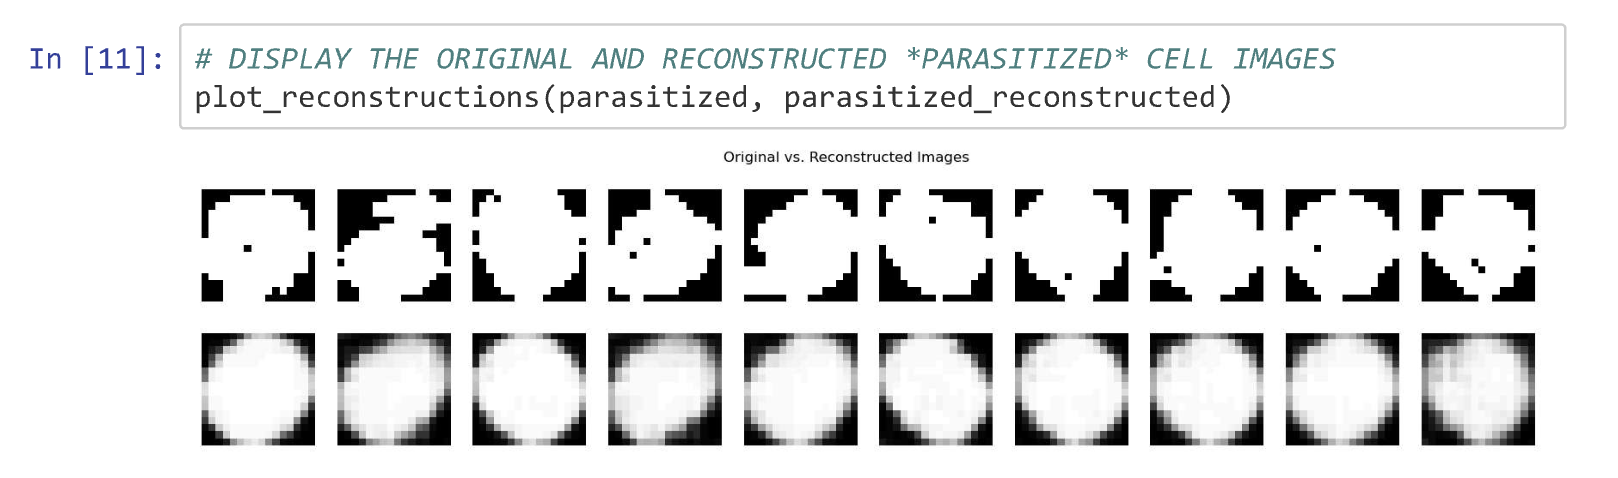

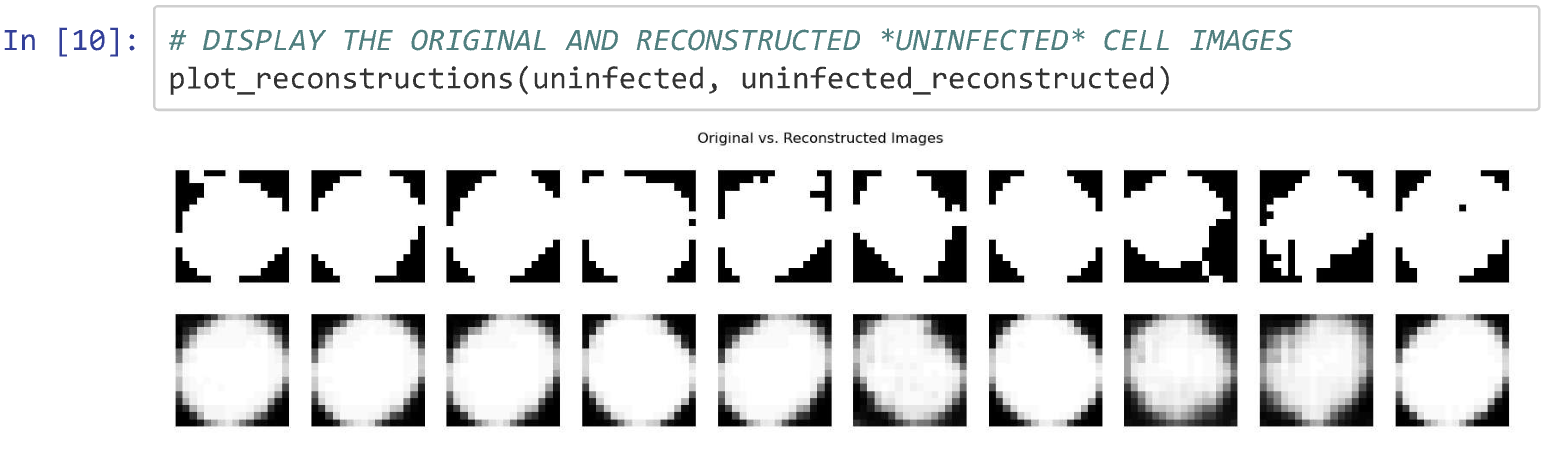